In [294]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment, EnvOut
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
from thinker.gym.asyn_vector_env import AsyncVectorEnv
from torch import nn
import thinker.util as util
import gym
import gym_csokoban

def gplot(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    if type(x) == torch.Tensor: x = x.cpu()
    if type(x) == np.ndarray: x = torch.tensor(x)       
    ax.imshow(torch.swapaxes(torch.swapaxes(x,0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


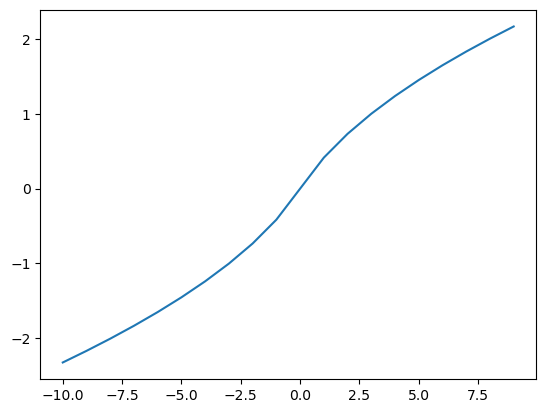

In [298]:
class RewardOnehot(nn.Module):    
    def __init__(self, support=300, eps=0.001):
        super(RewardOnehot, self).__init__()
        self.support = support
        self.eps = eps
        self.dec = torch.arange(-support, support + 1, 1)

    def forward(self, x):
        """encode the scalar reward or values to one-hot encoding 
        according to MuZero"""
        with torch.no_grad():
            sup, eps = self.support, self.eps
            enc_s = torch.sign(x)*(torch.sqrt(torch.abs(x)+1)-1)+eps*x
            enc_s = torch.clamp(enc_s, -sup, +sup)
            enc_v = torch.zeros(enc_s.shape+(2*sup+1,), dtype=torch.float32, device=enc_s.device)        
            enc_s_floor = torch.floor(enc_s)
            enc_v_reminder = enc_s - enc_s_floor
            enc_s_floor = enc_s_floor.long().unsqueeze(-1)
            enc_v.scatter_(-1, torch.clamp_max(sup+enc_s_floor+1, 2*sup) , enc_v_reminder.unsqueeze(-1))
            enc_v.scatter_(-1, sup+enc_s_floor, 1-enc_v_reminder.unsqueeze(-1))        
            self.enc_s = enc_s
            return enc_v

    def decode(self, x):
        """dncode the one-hot encoding to scalar according to MuZero"""    
        with torch.no_grad():  
            sup, eps = 300, 0.001     
            dec = torch.arange(-sup, sup+1, 1)
            dec_v = torch.sum(dec*x, dim=-1)   
            return torch.sign(dec_v)*(torch.square((torch.sqrt(1+4*eps*(torch.abs(dec_v)+1+eps))-1)/(2*eps)) - 1)

def reward_enc(x, sup=300, eps=0.0001):
    return torch.sign(x)*(torch.sqrt(torch.abs(x)+1)-1)+eps*x

def reward_dec(x, sup=300, eps=0.0001):
    return torch.sign(x)*(torch.square((torch.sqrt(1+4*eps*(torch.abs(x)+1+eps))-1)/(2*eps)) - 1)




rewardTran = RewardTran()
x = np.arange(-10, 10, 1)
x = torch.tensor(x)
y = rewardTran(x)
x_ = rewardTran.decode(y)
plt.plot(x, rewardTran.enc_s)

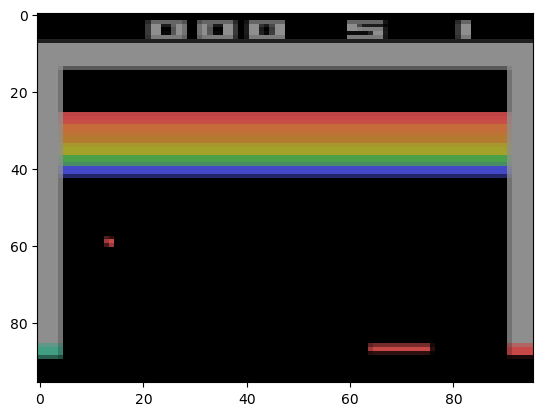

In [217]:
import thinker.env

flags = util.parse([])
flags.rec_t = 5
flags.env = "BreakoutNoFrameskip-v4"
flags.actor_see_p = 1
flags.actor_drc = True
env = Environment(flags)
model_net = ModelNet((12,96,96), 4, flags)
env_out, _ = env.initial(model_net)
gplot(env_out.gym_env_out[0,0,:3])

tensor([[1]])


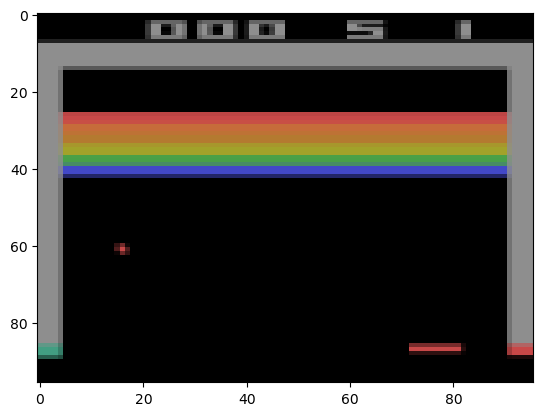

In [209]:
action = [3,1,0]
env_out, _ = env.step(torch.tensor(action).unsqueeze(0).unsqueeze(0), model_net)
print(env_out.cur_t)
gplot(env_out.gym_env_out[0,0,-3:])

In [218]:
actor_net = ActorNet(obs_shape=env.model_out_shape, 
                     gym_obs_shape=env.gym_env_out_shape,
                     num_actions=env.num_actions, 
                     flags=flags)
actor_state = actor_net.initial_state(1)
actor_out, actor_state = actor_net(env_out, actor_state)
actor_out.policy_logits

tensor([[[0.0067, 0.0371, 0.0242, 0.0380]]], grad_fn=<ViewBackward0>)

TypeError: Invalid shape (3, 96, 96) for image data

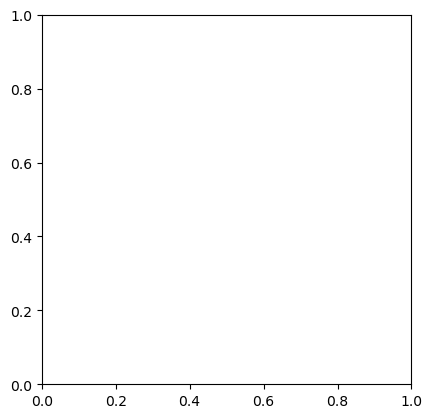

In [39]:
import thinker.env

env = gym.make("BreakoutNoFrameskip-v4")
env = thinker.env.PreWrap(env, "BreakoutNoFrameskip-v4")
#env = gym.make("BreakoutNoFrameskip-v4")

st = time.time()
obs = env.reset()         
state = env.clone_state()
plt.figure(0)
plt.imshow(obs[:3,:,:])
env.step(0)
for _ in range(200):
    obs, reward, done, info = env.step(3)
    if done: obs = env.reset()
print(time.time() - st)    
plt.figure(1)
plt.imshow(obs[0,:,:])

env.restore_state(state)
obs, reward, done, info = env.step(0)
plt.figure(2)
plt.imshow(obs[0,:,:])


In [ ]:
from thinker.util import Timings
import thinker.env

flags = util.parse([])
flags.rec_t = 5
flags.flex_t = False

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)

def check_diff(env_out, env_out_, ind, n):
    check = ['gym_env_out', 'model_out', 'reward', 'done', 
        'episode_return', 'episode_step', 'cur_t', 'last_action',
        'max_rollout_depth']
    for c in check:
        d = torch.sum(torch.abs(getattr(env_out, c)[:,[ind]].cpu().float() - getattr(env_out_, c).cpu().float()))
        if d > 1e-4:
            if not c == 'gym_env_out':
                print(getattr(env_out, c)[[ind]], getattr(env_out_, c))
            else:
                gplot(getattr(env_out, 'gym_env_out')[0,ind].cpu())
                gplot(getattr(env_out_, 'gym_env_out')[0,0].cpu())
            raise Exception("%d [%d] check not passed: %s %f" %(n, ind, c, d))

torch.set_printoptions(precision=5)
env_n = 2
device = torch.device("cuda")

model_net_ = ModelNet((3,80,80), 5, flags)
model_net_.load_state_dict({k: v.cpu() for k, v in model_net.state_dict().items()})
model_net_.train(False)

env = Environment(flags, env_n=env_n, device=device)
env.seed(np.arange(env_n))
model_net.to(device)
env_out, _ = env.initial(model_net)

env_ = [Environment(flags) for _ in range(env_n)]
env_out_ = []
for n in range(env_n): 
    env_[n].seed([n])
    env_out_single, _ = env_[n].initial(model_net_)
    env_out_.append(env_out_single)
    check_diff(env_out, env_out_single, n, 0)

timings = Timings()

#for n in range(env_n): gplot(env_out.gym_env_out[0,n].cpu())

for n in range(1000):
    timings.reset()
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            #np.random.randint(2)
                            ] for _ in range(env_n)])
    timings.time("s0")
    env_out, _ = env.step(action.unsqueeze(0).to(device), model_net, None)
    timings.time("s1")
    env_out_ = []
    for m in range(env_n):
        env_out_single, _ = env_[m].step(action.unsqueeze(0)[:,[m]], model_net_, None)
        env_out_.append(env_out_single)
        check_diff(env_out, env_out_single, m, n+1)
    timings.time("s2")
    
    if env_[0].env.baseline_max_q is not None:
        env_bmaxq = torch.tensor([e.env.baseline_max_q for e in env_])
        env_bmeanq = torch.tensor([e.env.baseline_mean_q for e in env_])
        diff_max_q = torch.sum(torch.abs(env.env.baseline_max_q.cpu() - env_bmaxq))
        diff_mean_q = torch.sum(torch.abs(env.env.baseline_mean_q.cpu() - env_bmeanq))
        if diff_max_q > 1e-4 or diff_mean_q > 1e-4:
            raise Exception("diff in max_q: %f mean_q %f" % (diff_max_q, diff_mean_q))

    last_env_out = env_out
    last_env_out_ = env_out_
    if n % 50 == 0: print(n)

print(timings.summary())    

In [ ]:
from PIL import Image
def save_img(x, name):
    x = env_out.gym_env_out[0,0]
    x = x.cpu()
    im = Image.fromarray(torch.swapaxes(torch.swapaxes(x,0,2),0,1).numpy())
    im.save(name)


In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.actor_see_p = 0
flags.actor_drc = True
flags.rec_t = 5

env = Environment(flags)
model_net = ModelNet((3,80,80), 5, flags)
env_out, model_state = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, 5, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

a = torch.tensor([1,1,1]).long().unsqueeze(0).unsqueeze(0)
actor_state = actor_net.initial_state(1)

for n in range(5):
   env_out, model_state = env.step(a, model_net, model_state)
   actor_out, actor_state = actor_net(env_out, actor_state)

In [ ]:
a = torch.tensor([4,2,0]).long().unsqueeze(0).unsqueeze(0)
env_out, model_state = env.step(a, model_net, model_state)
cur_t = env_out.cur_t
x = env_out.gym_env_out[0]
plot_gym_env_out(x)
print(env_out.cur_t, env_out.see_mask, env.env.baseline_max_q)
device = torch.device("cuda")
actor_net.to(device)
actor_state = util.tuple_map(actor_state, lambda x: x.to(device))
env_out = util.tuple_map(env_out, lambda x: x.to(device))

out, actor_state = actor_net(env_out, actor_state)
print([x.dtype for x in out[0] if x is not None])


In [ ]:
k = 3
t = 4
n = 1
next_ind = np.array([3, np.nan, np.nan])

base_ind = 2 * n
base_ind_pri = t * base_ind

abs_flat_inds = np.array([6 + base_ind_pri, 5 + base_ind_pri])

# compute the correct index to update; if the indexes are across blocks,
# we have to carry the overflowing index to the next block

flat_inds = abs_flat_inds - base_ind_pri # get the relative index
mask = flat_inds > 0 
flat_inds = flat_inds[mask] 

flat_inds = flat_inds[:, np.newaxis] + np.arange(k) # flat_inds now stores uncarried indexes
flat_inds_block = flat_inds // (t * n) # block index of flat_inds
carry_mask = ~(flat_inds_block[:,[0]] == flat_inds_block).reshape(-1) 
# if first index block is not the same as the later index block, we need to carry it

flat_inds = flat_inds.reshape(-1)
flat_inds_block = flat_inds_block.reshape(-1)
carry_inds_block = next_ind[flat_inds_block[carry_mask]-1] - base_ind // n  # the correct index block

flat_inds = flat_inds.astype(float)
flat_inds[carry_mask] = flat_inds[carry_mask] + (-flat_inds_block[carry_mask] + carry_inds_block) * (t * n) 
mask = ~np.isnan(flat_inds)
flat_inds = flat_inds[mask].astype(int)
print(flat_inds_block)
print(carry_mask)
print(carry_inds_block)
print(flat_inds)

In [ ]:

flags = util.parse([])
flags.model_batch_size = 2
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False
flags.model_rnn = True
flags.model_unroll_length = 8
t = flags.model_unroll_length   
flags.model_k_step_return = 5
k = flags.model_k_step_return
flags.actor_parallel_n = 1
n = flags.actor_parallel_n  

flags.model_batch_mode = True

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),c), torch.full((t+k, n, 1),c+0.1))    
    state = (torch.full((n, 3),c+0.2), torch.full((n, 3),c+0.3))
    model_buffer.write(data, state, np.random.randint(10))

print(model_buffer.next_inds)
data, data_state, weights, abs_flat_inds, inds = model_buffer.read(1)
print(data.x[:, :, -1], data_state)

state = tuple(torch.zeros_like(x) for x in data_state)
priorities = torch.zeros(len(abs_flat_inds))

model_buffer.update_priority(abs_flat_inds, priorities, state)



In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.model_rnn = True

model_net_1 = ModelNet((3,80,80), 5, flags)
nc = model_net_1
print("network size: ", sum(p.numel() for p in nc.parameters()))

flags.model_rnn = False
model_net_2 = ModelNet((3,80,80), 5, flags)
nc = model_net_2
print("network size: ", sum(p.numel() for p in nc.parameters()))

In [ ]:
tran = {"conv1":  "output_rvpi.conv1",
        "conv2":  "output_rvpi.conv2",
        "policy": "output_rvpi.fc_logits",
        "baseline": "output_rvpi.fc_v",
        "r": "output_rvpi.fc_r",
        "frame_conv.0":  "output_rvpi.conv1",
        "frame_conv.2":  "output_rvpi.conv2",}

state_dict = {}
for k in model_net_1.state_dict().keys():
    #print(k)
    if k not in model_net_2.state_dict().keys():
        for p, q in tran.items():
            if k[:len(p)+1] == p+".":
                out = q + k[len(p):]
                break
    else:
        out = k
    state_dict[k] = model_net_2.state_dict()[out]

model_net_1.load_state_dict(state_dict)
model_net_1.train(False)
model_net_2.train(False)

x = torch.rand(4, 3, 80, 80) * 2555
actions = torch.zeros(1, 4, dtype=torch.long)
done = torch.zeros(1, 4, dtype=torch.bool)

state = model_net_1.init_state(4)
vs, logits, states = model_net_1(x=x.unsqueeze(0), actions=actions, done=done, state=state)
print(logits)

rs, vs, logits, encodeds = model_net_2(x=x, actions=actions)
print(logits)